In [ ]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [67]:
class DotDict(dict):
    """Dictionary allowing attribute-style access (x.key) and dot completion."""
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(f"'DotDict' object has no attribute '{name}'")

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        try:
            del self[name]
        except KeyError:
            raise AttributeError(f"'DotDict' object has no attribute '{name}'")

    def copy(self):
        return DotDict(super().copy())


@dataclass
class Paths:
    paths: DotDict
    time_grid: np.ndarray
    num_steps: int
    num_paths: int
    dt: float 

    
        

In [351]:
class BS:
    @staticmethod
    def premium(s0, k, ttm, r, sigma, flag=1):
        d1 = (np.log(s0 / k) + (r + 0.5 * sigma * sigma) * ttm) / (sigma * np.sqrt(ttm))
        d2 = d1 - sigma * np.sqrt(ttm)
        return flag * s0 * norm.cdf(flag * d1) - flag * k * np.exp(-r * ttm) * norm.cdf(
            flag * d2
        )

    @staticmethod
    def delta(s0, k, ttm, r, sigma, flag=1):
        d1 = (np.log(s0 / k) + (r + 0.5 * sigma * sigma) * ttm) / (sigma * np.sqrt(ttm))
        return flag * norm.cdf(flag * d1, 0.0, 1.0)

    @staticmethod
    def gamma(s0, k, ttm, r, sigma, flag=1):
        d1 = (np.log(s0 / k) + (r + 0.5 * sigma * sigma) * ttm) / (sigma * np.sqrt(ttm))
        return norm.pdf(d1, 0.0, 1.0) / (s0 * sigma * np.sqrt(ttm))


class GBM:
    @staticmethod
    def paths(s0, mu, sigma, ttm, num_paths=1_000, num_steps=1_000, seed=0) -> Paths:
        dt = ttm / num_steps
        time_grid = np.linspace(0, ttm, num_steps + 1)
        rng = np.random.default_rng(seed)
        dw = rng.normal(size=(num_paths, num_steps)) * np.sqrt(dt)
        w = np.zeros((num_paths, num_steps + 1))
        w[:, 1:] = np.cumsum(dw, axis=1)
        s = s0 * np.exp(sigma * w + (mu - 0.5 * sigma * sigma) * time_grid)
        return Paths(
            paths=DotDict({"brownian_shocks": dw, "underlying": s}),
            time_grid=time_grid,
            dt=dt,
            num_steps=num_steps,
            num_paths=num_paths,
        )


class Simulation:

    @staticmethod
    def delta_hedge(paths, sigma_implied, sigma_hedge, k, ttm, r):
        # --- Delta-Hedging Simulation ---
        num_paths, num_steps = paths.shape
        dt = ttm / num_steps

        # Allocate arrays for portfolio components
        opt_mtm = np.zeros((num_paths, num_steps))  # Option mark-to-market
        cash_acc = np.zeros((num_paths, num_steps))  # Risk-free cash account
        hedge_ptf = np.zeros((num_paths, num_steps))  # Replicating portfolio
        pnl_total = np.zeros((num_paths, num_steps))  # Total PnL

        # --- Initialize at t = 0 ---
        opt_mtm[:, 0] = BS.premium(paths[:, 0], k, ttm, r, sigma_implied)
        delta = BS.delta(paths[:, 0], k, ttm, r, sigma_hedge)
        cash_acc[:, 0] = opt_mtm[:, 0] - delta * paths[:, 0]
        hedge_ptf[:, 0] = delta * paths[:, 0] + cash_acc[:, 0]
        pnl_total[:, 0] = 0.0

        for t in range(1, num_steps):
            tau = ttm - t * dt

            # Update option MTM
            opt_mtm[:, t] = BS.premium(paths[:, t], k, tau, r, sigma_implied)

            # Accrue cash at risk-free rate
            cash_acc[:, t] = cash_acc[:, t - 1] * (1.0 + r * dt)

            # Rebalance hedge
            delta_prev = delta
            delta = BS.delta(paths[:, t], k, tau, r, sigma_hedge)
            cash_acc[:, t] -= (delta - delta_prev) * paths[:, t]

            # Update replicating portfolio
            hedge_ptf[:, t] = delta * paths[:, t] + cash_acc[:, t]

            # Compute total PnL relative to initial theoretical difference
            pnl_total[:, t] = (opt_mtm[:, t] - hedge_ptf[:, t]) - (
                opt_mtm[:, 0] - hedge_ptf[:, 0]
            ) * (1.0 + r * dt) ** t

        # --- Final step at maturity ---
        opt_mtm[:, -1] = np.maximum(paths[:, -1] - k, 0.0)
        cash_acc[:, -1] = cash_acc[:, num_steps - 1] * (1.0 + r * dt)
        hedge_ptf[:, -1] = delta * paths[:, -1] + cash_acc[:, -1]
        pnl_total[:, -1] = (opt_mtm[:, -1] - hedge_ptf[:, -1]) - (
            opt_mtm[:, 0] - hedge_ptf[:, 0]
        ) * (1.0 + r * dt) ** num_steps

        return pnl_total




In [295]:
time_to_maturity = 2.
s0 = 100.
k = 110.
mu = 0.1
r = 0.05

sigma_h = 0.4 # sigma hedged
sigma_i = 0.2 # sigma implied/market
sigma_a = 0.4 # sigma actual/model


In [454]:
gbm = GBM.paths(s0, mu, sigma_a, time_to_maturity, num_paths=1_000, num_steps=1_000) 


***Case 1.1: Hedge with Actual Volatility, $\sigma$: mark to market delta hedging***

$$
    dV_i - \Delta_a dS - r(V_i - \Delta_a S)dt
$$

In [455]:
pnl_1_1 = \
    Simulation.delta_hedge(
        paths=gbm.paths.underlying, sigma_implied=sigma_i, sigma_hedge=sigma_a, ttm=time_to_maturity, k=k, r=r)

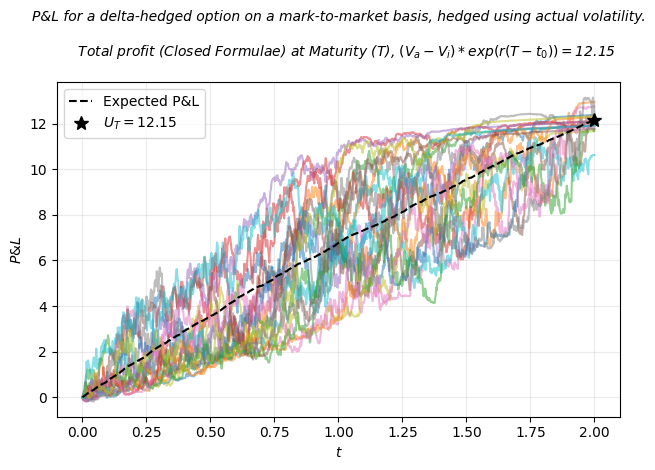

In [456]:
v_a = BS.premium(s0, k, time_to_maturity, r, sigma_a) 
v_i = BS.premium(s0, k, time_to_maturity, r, sigma_i)

fig, ax = plt.subplots()
n = np.random.randint(0,100)

ax.set_title(
    f"""P&L for a delta-hedged option on a mark-to-market basis, hedged using actual volatility.\n
    Total profit (Closed Formulae) at Maturity (T), $(V_a - V_i) * exp(r (T - t_0)) = ${(v_a - v_i) * np.exp(r * time_to_maturity):.2f}
    """, size=10., style='italic')

np.average(pnl_1_1[:, -1]), np.std(pnl_1_1[:, -1])

ax.plot(gbm.time_grid, pnl_1_1[:min(20, gbm.num_paths), :].T, alpha=0.5)
ax.plot(gbm.time_grid, np.mean(pnl_1_1, axis=0), 'k--', label="Expected P&L")
ax.plot(gbm.time_grid[-1], np.mean(pnl_1_1[:, -1]), 'k*', label=f'$U_T={np.mean(pnl_1_1[:, -1]):.2f}$', ms=10)

ax.set(xlabel="$t$", ylabel="$P&L$")
ax.legend(handlelength=1.65)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()


***Case 1.2: Hedge with Actual Volatility, $\sigma$: mark to market (using Itô’s lemma)***

\begin{align}
    \theta_i\,dt + \Delta_i\,dS + \tfrac{1}{2}\sigma^2 S^2 \Gamma_i\,dt - \Delta_a\,dS - r(V_i - \Delta_a S)\,dt = \nonumber \\
    \tfrac{1}{2}(\sigma^2 - \tilde{\sigma}^2) S^2 \Gamma_i\,dt + (\Delta_i - \Delta_a)\big[(\mu - r)S\,dt + \sigma S\,dX\big].
\end{align}

In [496]:
pnl_1_2 = np.zeros((gbm.num_paths, gbm.num_steps + 1))
for t in range(0, gbm.num_steps):
    delta_i = BS.delta(gbm.paths.underlying[:, t], k, time_to_maturity - t * gbm.dt, r, sigma_i) 
    delta_a = BS.delta(gbm.paths.underlying[:, t], k, time_to_maturity - t * gbm.dt, r, sigma_a) 
    gamma = BS.gamma(gbm.paths.underlying[:, t], k, time_to_maturity - t * gbm.dt, r, sigma_i) 
    pnl_1_2[:, t+1] = pnl_1_2[:, t] + 0.5 * (sigma_a ** 2 - sigma_i ** 2) * gamma * gbm.paths.underlying[:, t] ** 2 * gbm.dt + \
        (delta_i - delta_a) * ((mu - r) * gbm.paths.underlying[:, t] * gbm.dt + sigma_a * gbm.paths.underlying[:, t] * gbm.paths.brownian_shocks[:,t])
    

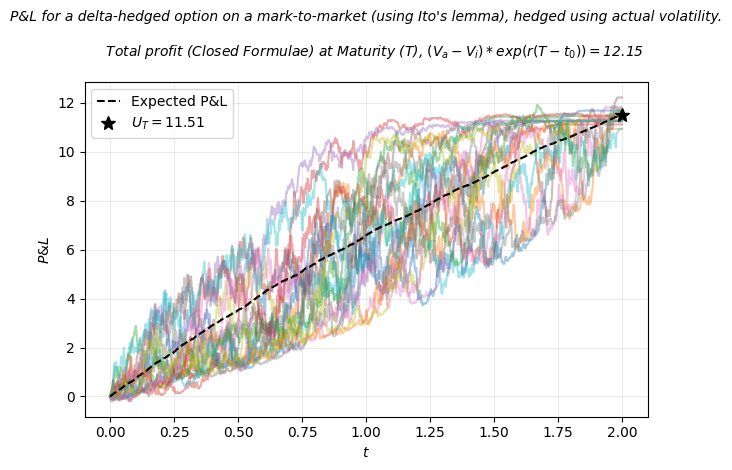

In [549]:
fig, ax = plt.subplots()
n = np.random.randint(0,100)

np.average(pnl_1_2[:, -1]), np.std(pnl_1_2[:, -1])

ax.set_title(
    f"""P&L for a delta-hedged option on a mark-to-market (using Ito's lemma), hedged using actual volatility.\n
    Total profit (Closed Formulae) at Maturity (T), $(V_a - V_i) * exp(r (T - t_0)) = ${(v_a - v_i) * np.exp(r * time_to_maturity):.2f}
    """, size=10., style='italic')

ax.plot(gbm.time_grid, pnl_1_2[:min(20, gbm.num_paths), :].T, alpha=0.4)
ax.plot(gbm.time_grid, np.mean(pnl_1_2, axis=0), 'k--', label="Expected P&L")
ax.plot(gbm.time_grid[-1], np.mean(pnl_1_2[:, -1]), 'k*', label=f'$U_T={np.mean(pnl_1_2[:, -1]):.2f}$', ms=10)

ax.set(xlabel="$t$", ylabel="$P&L$")

ax.legend(handlelength=1.65)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()


***Case 2.1: Hedge with Implied Volatility, $\tilde{\sigma}$: mark to market delta hedging***

In [459]:
pnl_2_1 = \
    Simulation.delta_hedge(
        paths=gbm.paths.underlying, sigma_implied=sigma_i, sigma_hedge=sigma_i, ttm=time_to_maturity, k=k, r=r)

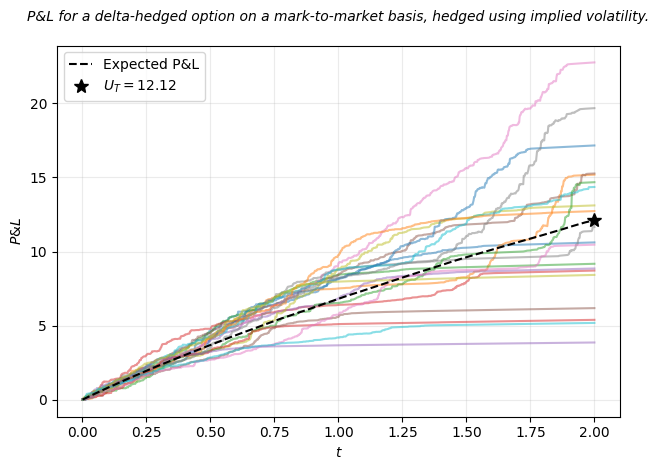

In [460]:
fig, ax = plt.subplots()
n = np.random.randint(0,100)

ax.set_title(
    f"""P&L for a delta-hedged option on a mark-to-market basis, hedged using implied volatility.\n""", size=10., style='italic')

np.average(pnl_2_1[:, -1]), np.std(pnl_2_1[:, -1])

ax.plot(gbm.time_grid, pnl_2_1[:min(20, gbm.num_paths), :].T, alpha=0.5)
ax.plot(gbm.time_grid, np.mean(pnl_2_1, axis=0), 'k--', label="Expected P&L")
ax.plot(gbm.time_grid[-1], np.mean(pnl_2_1[:, -1]), 'k*', label=f'$U_T={np.mean(pnl_2_1[:, -1]):.2f}$', ms=10)

ax.set(xlabel="$t$", ylabel="$P&L$")
ax.legend(handlelength=1.65)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

***Case 2.2: Hedge with Implied Volatility, $\tilde{\sigma}$: mark to market (using Itô’s lemma)***

$$
\tfrac{1}{2}(\sigma^2 - \tilde{\sigma}^2) S^2 \Gamma_i\,dt
$$

In [551]:
pnl_2_2 = np.zeros((gbm.num_paths, gbm.num_steps + 1))
for t in range(0, gbm.num_steps):
    gamma = BS.gamma(gbm.paths.underlying[:, t], k, time_to_maturity - t * gbm.dt, r, sigma_i) 
    pnl_2_2[:, t+1] = pnl_2_2[:, t] + 0.5 * (sigma_a ** 2 - sigma_i ** 2) * gamma * gbm.paths.underlying[:, t] ** 2 * gbm.dt


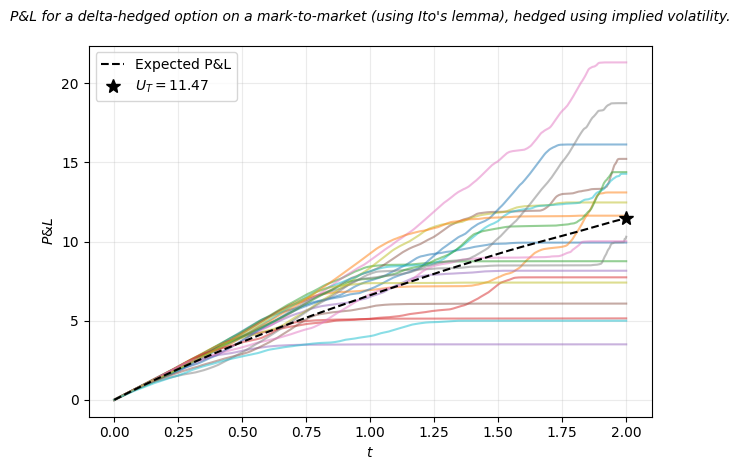

In [552]:
fig, ax = plt.subplots()
n = np.random.randint(0,100)

ax.set_title(
    f"""P&L for a delta-hedged option on a mark-to-market (using Ito's lemma), hedged using implied volatility.\n""", size=10., style='italic')

np.average(pnl_2_2[:, -1]), np.std(pnl_2_2[:, -1])

ax.plot(gbm.time_grid, pnl_2_2[:min(20, gbm.num_paths), :].T, alpha=0.5)
ax.plot(gbm.time_grid, np.mean(pnl_2_2, axis=0), 'k--', label="Expected P&L")
ax.plot(gbm.time_grid[-1], np.mean(pnl_2_2[:, -1]), 'k*', label=f'$U_T={np.mean(pnl_2_2[:, -1]):.2f}$', ms=10)

ax.set(xlabel="$t$", ylabel="$P&L$")
ax.legend(handlelength=1.65)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()